In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Resizing, Rescaling,Dense,InputLayer,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

In [3]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 98% 303M/309M [00:03<00:00, 80.1MB/s]
100% 309M/309M [00:03<00:00, 87.5MB/s]


In [7]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/human-emotions-datasethes"

Streaming output truncated to the last 5000 lines.
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/human-emotions-datasethes/EmotionsDataset/data/nothing/73

In [31]:
train_directory="/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
val_directory="/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"
labels=['angry','happy','sad']
config={
    "batch":32,
    "img_size":265,
    "LR":0.001,
    "epochs":20,
    "Dropout":0.2,
    "Regul_rate":0.0,
    "optimizer":"adam",
    "filters":6,
    "k_size":3,
    "strides":1,
    "pool_size":2,
    "dense_1":100,
    "dense_2":10,
    "n_classes":3,
}

In [9]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=labels,
    color_mode='rgb',
    batch_size=config['batch'],
    image_size=(config['img_size'], config['img_size']),
    shuffle=True,
    seed=99,
    interpolation='bilinear',
    verbose=True
)

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=labels,
    color_mode='rgb',
    batch_size=config['batch'],
    image_size=(config['img_size'], config['img_size']),
    shuffle=True,
    seed=99,
    interpolation='bilinear',
    verbose=True
)

Found 2278 files belonging to 3 classes.


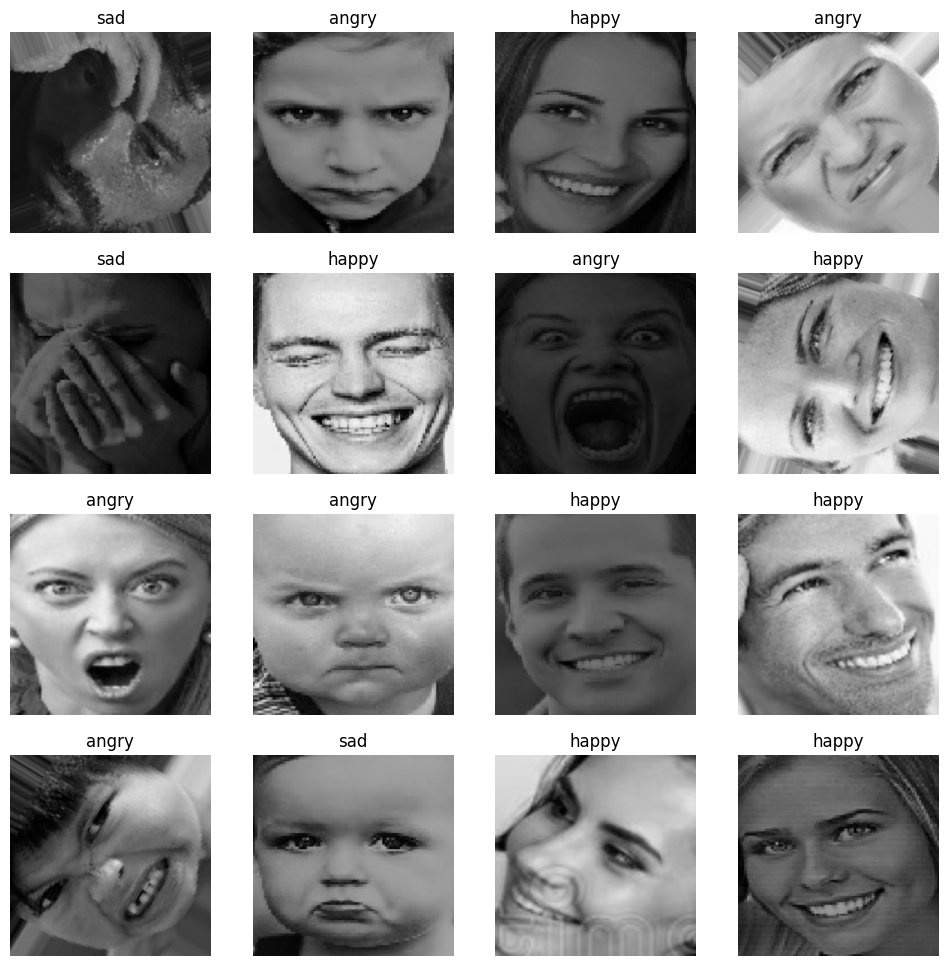

In [11]:
plt.figure(figsize=(12,12))
for image, label in train_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(labels[np.argmax(label[i])])
    plt.axis('off')

In [12]:
tranining_dataset=(train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE))
validation_dataset=(val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE))

In [13]:
resize_rescale=tf.keras.Sequential([
    Resizing(config['img_size'],config['img_size']),
    Rescaling(1./255)
])

In [14]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=10, restore_best_weights=True
)

In [32]:
model = Sequential([
    InputLayer(input_shape=(None,None,3)),
    resize_rescale,

    # First Convolutional Block
    Conv2D(filters=config['filters'], kernel_size=config['k_size'], strides=config['strides'], padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=config['pool_size'], strides=config['strides']),
    Dropout(0.3),  # Add Dropout after the first pooling layer

    # Second Convolutional Block
    Conv2D(filters=config['filters'], kernel_size=config['k_size'], strides=config['strides'], padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=config['pool_size'], strides=config['strides']),
    Dropout(0.3),  # Add Dropout after the second pooling layer

    Flatten(),

    # First Dense Block
    Dense(config['dense_1'], activation='relu', kernel_regularizer=L2(config['Regul_rate'])),
    BatchNormalization(),
    Dropout(0.5),  # Add Dropout after the first dense layer

    # Second Dense Block
    Dense(config['dense_2'], activation='relu', kernel_regularizer=L2(config['Regul_rate'])),
    BatchNormalization(),
    Dropout(0.5),  # Add Dropout after the second dense layer

    # Output Layer
    Dense(config['n_classes'], activation='softmax')
])

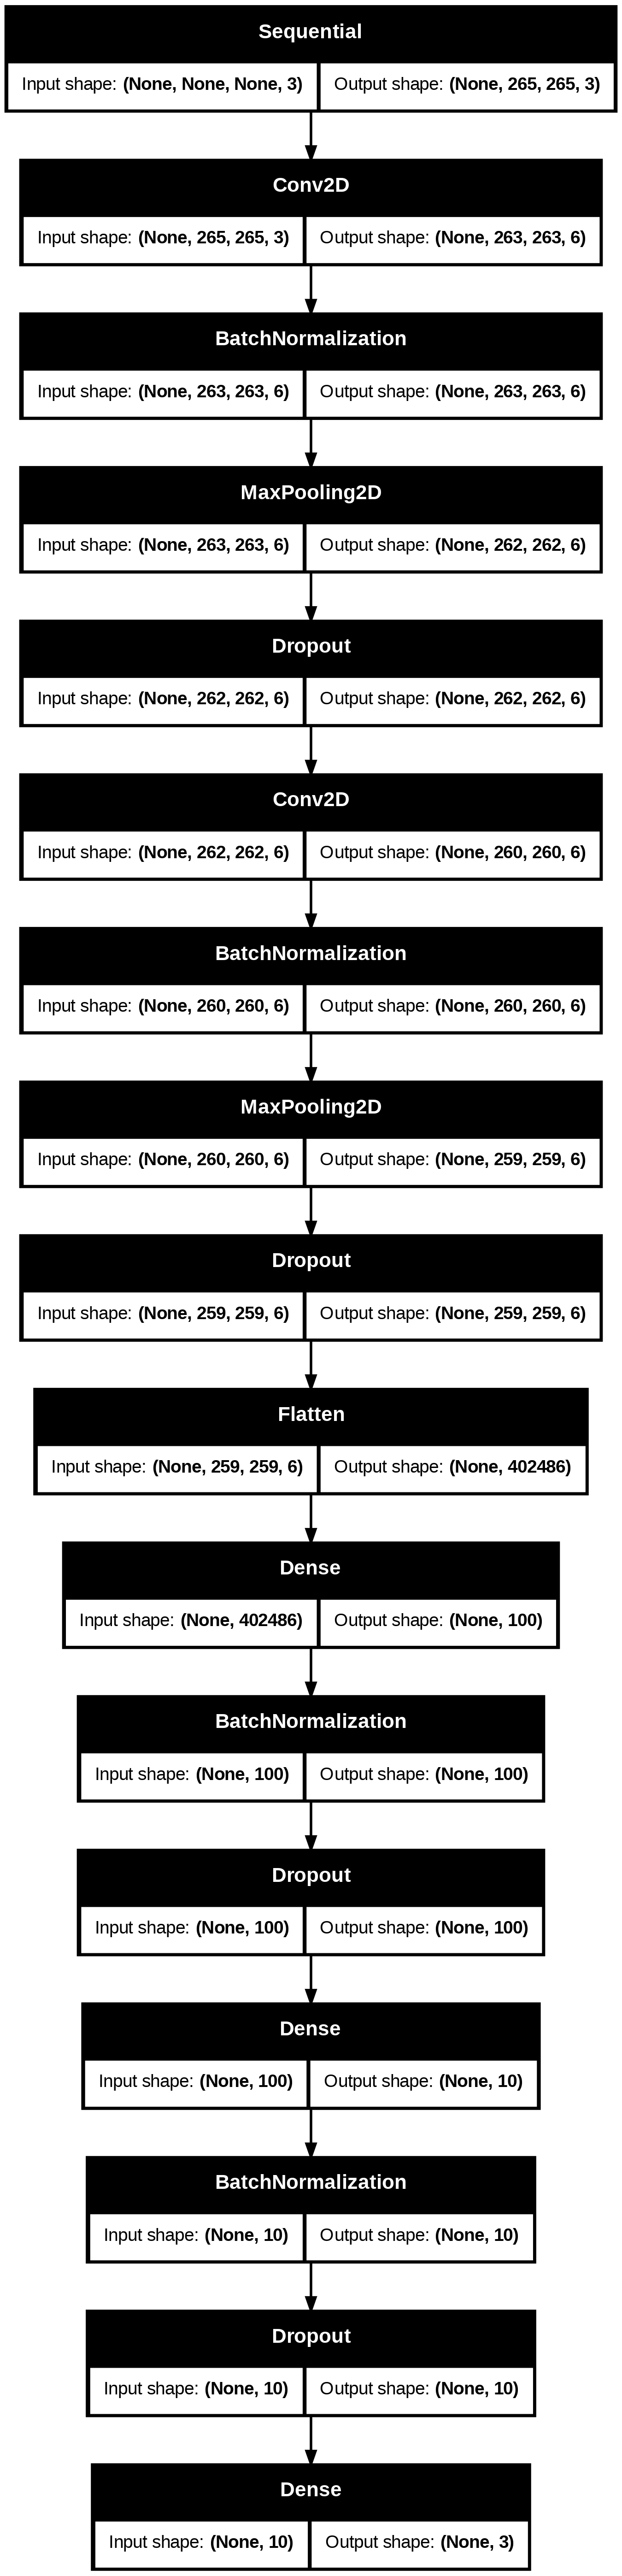

In [33]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [34]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k=2,name='topKAccuracy')]

In [35]:
model.compile(
    optimizer=Adam(learning_rate=config['LR']),
    loss=loss_function,
    metrics=metrics
)

In [36]:
history=model.fit(
    tranining_dataset,
    validation_data=validation_dataset,
    epochs=config['epochs'],
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.3858 - loss: 1.4529 - topKAccuracy: 0.7204 - val_accuracy: 0.4416 - val_loss: 1.0983 - val_topKAccuracy: 0.7230
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.4770 - loss: 1.1119 - topKAccuracy: 0.7749 - val_accuracy: 0.4522 - val_loss: 1.0537 - val_topKAccuracy: 0.7928
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.5262 - loss: 0.9780 - topKAccuracy: 0.8215 - val_accuracy: 0.4728 - val_loss: 0.9908 - val_topKAccuracy: 0.8042
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.5935 - loss: 0.8748 - topKAccuracy: 0.8562 - val_accuracy: 0.5751 - val_loss: 0.8783 - val_topKAccuracy: 0.8679
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.6385 - loss: 0.7983 - topKAccuracy: 0.8774 - val_accuracy: 0.5549 - val_loss: 0.9208 - val_topKAccuracy: 0.8543
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.6826 - loss: 0.7390 - topKAccura

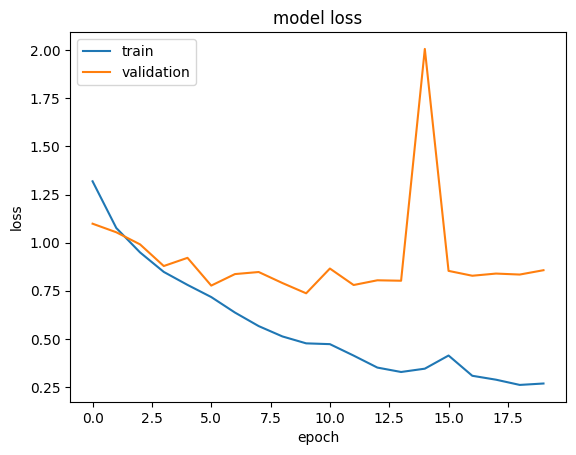

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

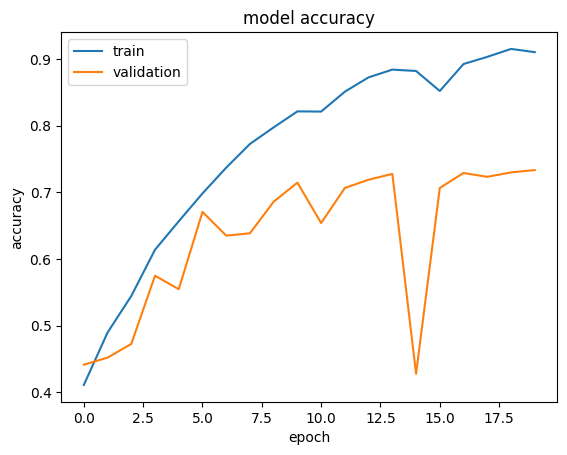

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7094 - loss: 0.7538 - topKAccuracy: 0.9053


[0.7365123629570007, 0.7146619558334351, 0.9047409892082214]

In [44]:
import cv2
image= cv2.imread('/content/human-emotions-datasethes/EmotionsDataset_Splitted/data/test/angry/101.jpg')
im = tf.constant(image, dtype=tf.float32)
im = tf.expand_dims(im, axis=0)
# im = resize_rescale(im)
print(labels[tf.math.argmax(model.predict(im),axis=-1).numpy()[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
angry


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


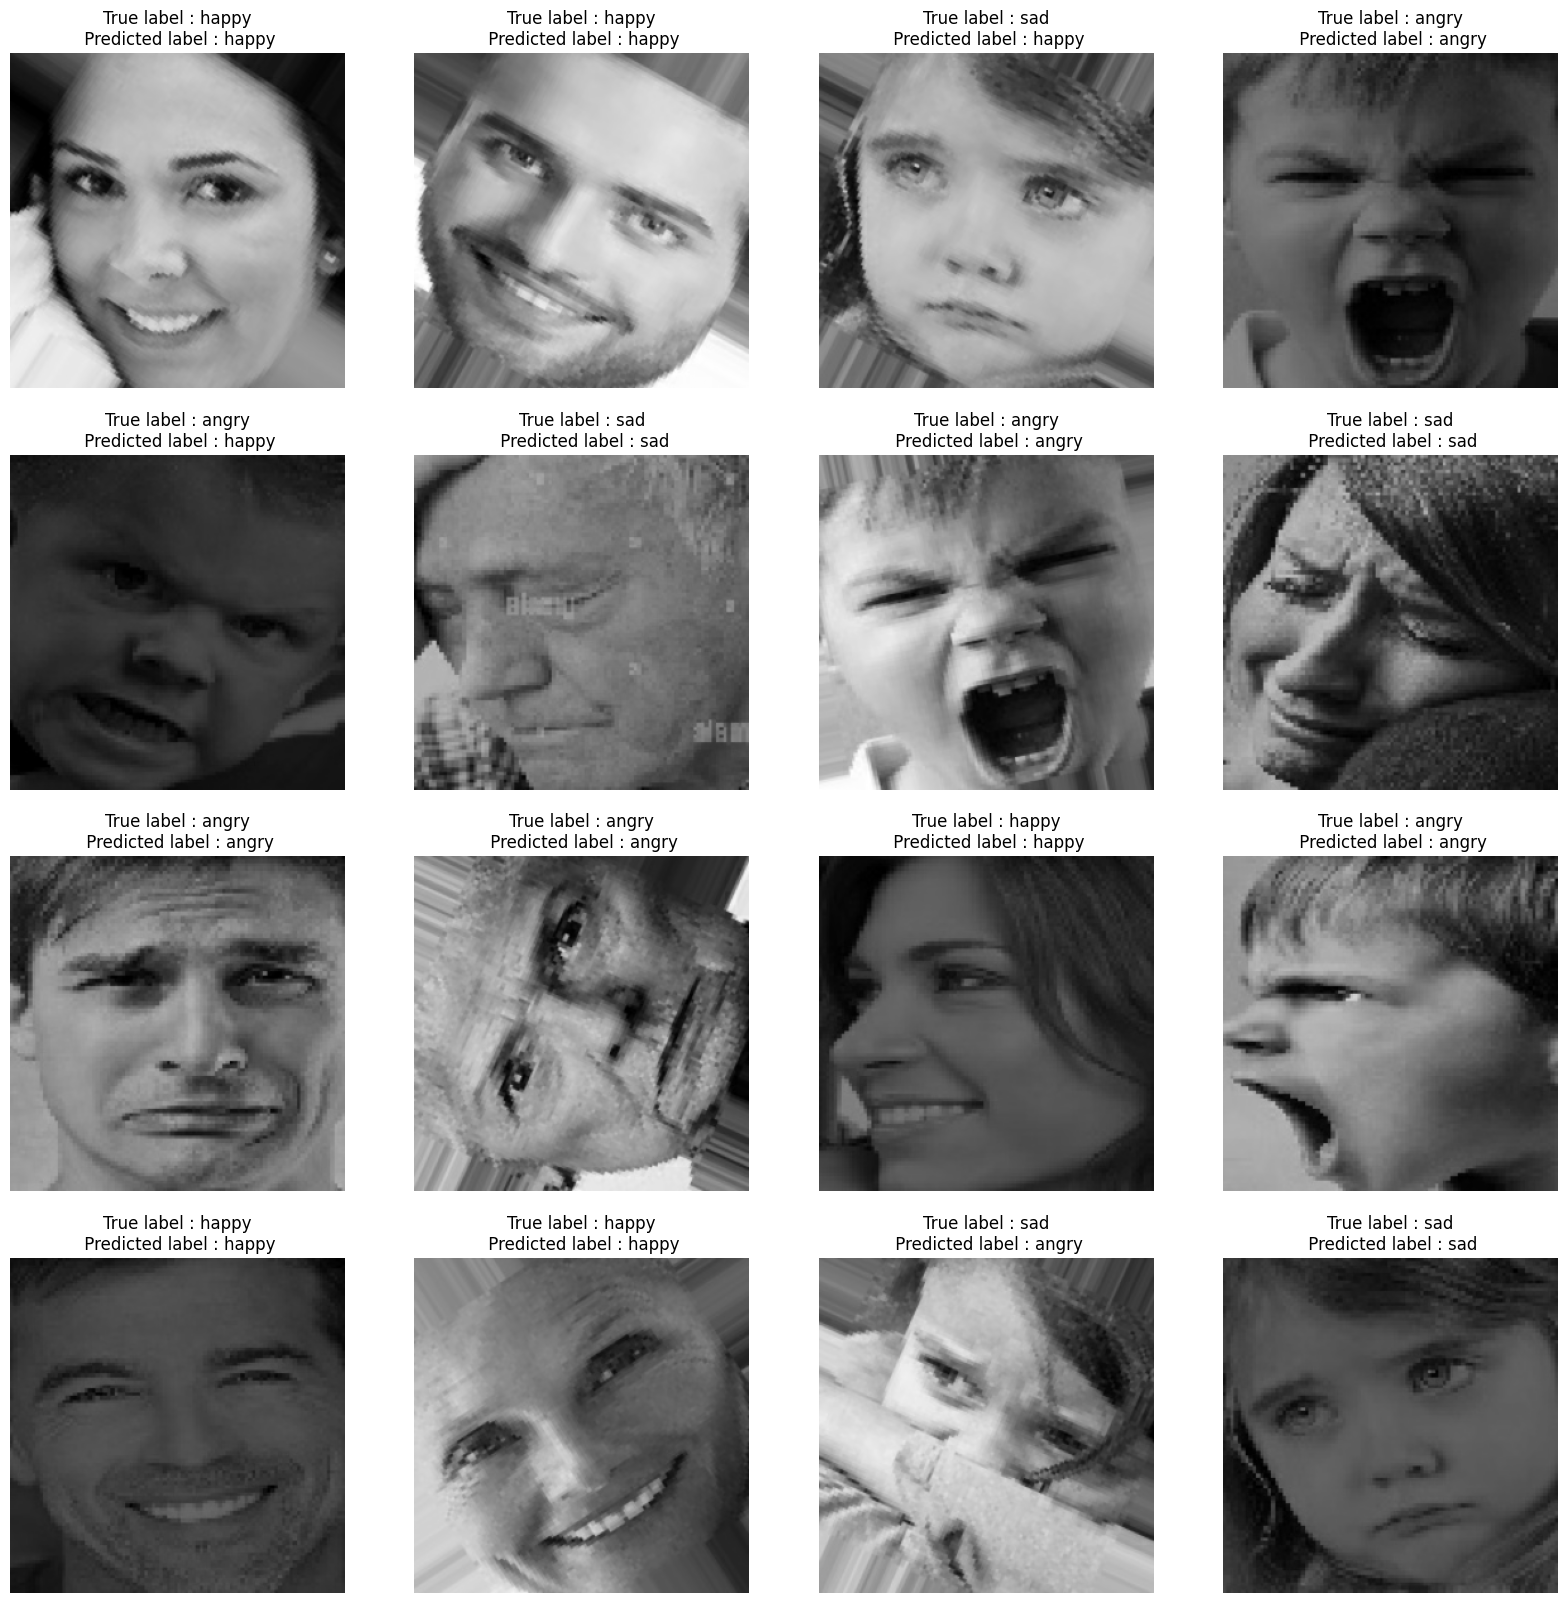

In [45]:
plt.figure(figsize=(20,20))
for image, label in validation_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(f"True label : {labels[tf.argmax(label[i],axis=0).numpy()] }\n Predicted label : {labels[tf.math.argmax(model.predict(tf.expand_dims(image[i],axis=0)),axis=-1).numpy()[0]]}")
    plt.axis('off')
